# King County - Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.regularizers import L2
import seaborn as sns
import time
from k_mean_cluster_util import k_mean_optimization, k_mean, random_initial_centroids

## Getting data ready
First We'll have some intuition on the data and set the "id" as index value. Also remove duplicate values.

In [2]:
df = pd.read_csv('./kc_house_data.csv')
df.set_index('id', inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.drop(['zipcode', 'waterfront', 'date'], axis=1)
prices = df['price']
df = df.drop('price', axis=1)
df['price'] = prices
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price
id,,,,,,,,,,,,,,,,,
7129300520,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,221900.0
6414100192,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,538000.0
5631500400,2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,180000.0
2487200875,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,604000.0
1954400510,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,510000.0


From date which is an object, "str" in this dataset, we'll have to convert to date and take year and month which is important to our model.

In [3]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df = df.drop('date', axis=1)
# df.head()

Have an intuition on what columns contain null values and what their Dtypes are

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 7129300520 to 1523300157
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21436 non-null  int64  
 1   bathrooms      21436 non-null  float64
 2   sqft_living    21436 non-null  int64  
 3   sqft_lot       21436 non-null  int64  
 4   floors         21436 non-null  float64
 5   view           21436 non-null  int64  
 6   condition      21436 non-null  int64  
 7   grade          21436 non-null  int64  
 8   sqft_above     21436 non-null  int64  
 9   sqft_basement  21436 non-null  int64  
 10  yr_built       21436 non-null  int64  
 11  yr_renovated   21436 non-null  int64  
 12  lat            21436 non-null  float64
 13  long           21436 non-null  float64
 14  sqft_living15  21436 non-null  int64  
 15  sqft_lot15     21436 non-null  int64  
 16  price          21436 non-null  float64
dtypes: float64(5), int64(12)
memory usag

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,21436.0,3.371571,0.929205,0.0000,3.0000,3.000,4.000,3.300000e+01
bathrooms,21436.0,2.117349,0.769913,0.0000,1.7500,2.250,2.500,8.000000e+00
sqft_living,21436.0,2082.704936,919.146469,290.0000,1430.0000,1920.000,2550.000,1.354000e+04
sqft_lot,21436.0,15135.637852,41538.620606,520.0000,5040.0000,7614.000,10696.250,1.651359e+06
floors,21436.0,1.496198,0.540388,1.0000,1.0000,1.500,2.000,3.500000e+00
view,21436.0,0.235118,0.767092,0.0000,0.0000,0.000,0.000,4.000000e+00
condition,21436.0,3.410384,0.650235,1.0000,3.0000,3.000,4.000,5.000000e+00
grade,21436.0,7.661737,1.174256,1.0000,7.0000,7.000,8.000,1.300000e+01
sqft_above,21436.0,1790.960440,829.026491,290.0000,1200.0000,1560.000,2220.000,9.410000e+03
sqft_basement,21436.0,291.744495,442.781983,0.0000,0.0000,0.000,560.000,4.820000e+03


In [6]:
(df == 0).sum()

bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
view             19320
condition            0
grade                0
sqft_above           0
sqft_basement    13015
yr_built             0
yr_renovated     20526
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price                0
dtype: int64

Correlation of two values gives a great insight on what features impact the values of each other

In [7]:
df.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price
bedrooms,1.000000,0.516772,0.577512,0.031719,0.175207,0.079542,0.027896,0.358396,0.478441,0.303035,0.153745,0.018435,-0.010228,0.129836,0.393161,0.029117,0.309007
bathrooms,0.516772,1.000000,0.754422,0.087143,0.499863,0.186684,-0.127839,0.664727,0.684994,0.283539,0.505092,0.051101,0.023444,0.221935,0.568194,0.086627,0.525453
sqft_living,0.577512,0.754422,1.000000,0.171957,0.352867,0.283753,-0.060973,0.762402,0.876683,0.434419,0.316544,0.055084,0.051118,0.239214,0.756205,0.182775,0.701993
sqft_lot,0.031719,0.087143,0.171957,1.000000,-0.005950,0.075012,-0.009298,0.112541,0.182581,0.015107,0.052447,0.007636,-0.085992,0.229555,0.143650,0.718097,0.088895
floors,0.175207,0.499863,0.352867,-0.005950,1.000000,0.028211,-0.266543,0.457475,0.522648,-0.246066,0.489062,0.005626,0.049279,0.124285,0.278854,-0.011917,0.256278
view,0.079542,0.186684,0.283753,0.075012,0.028211,1.000000,0.045051,0.249890,0.166930,0.276482,-0.055153,0.103633,0.005671,-0.079720,0.279077,0.072867,0.396933
condition,0.027896,-0.127839,-0.060973,-0.009298,-0.266543,0.045051,1.000000,-0.148248,-0.160782,0.174463,-0.364947,-0.061136,-0.015402,-0.107780,-0.095002,-0.003731,0.035089
grade,0.358396,0.664727,0.762402,0.112541,0.457475,0.249890,-0.148248,1.000000,0.756068,0.167032,0.445329,0.014357,0.113332,0.196572,0.712507,0.118313,0.667496
sqft_above,0.478441,0.684994,0.876683,0.182581,0.522648,0.166930,-0.160782,0.756068,1.000000,-0.052456,0.422838,0.022666,-0.001652,0.343115,0.731992,0.193413,0.605495
sqft_basement,0.303035,0.283539,0.434419,0.015107,-0.246066,0.276482,0.174463,0.167032,-0.052456,1.000000,-0.134590,0.071909,0.109208,-0.145846,0.199247,0.017283,0.323552


<AxesSubplot:>

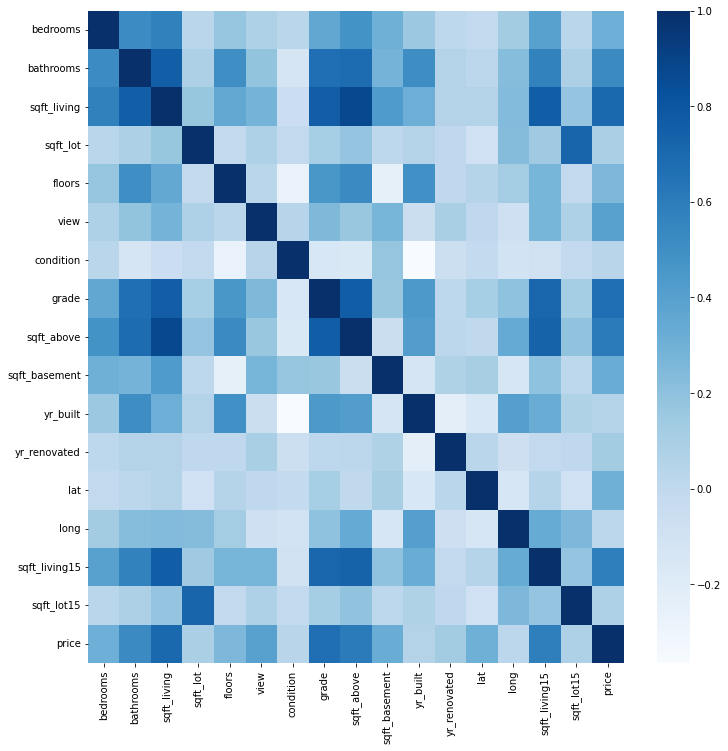

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap='Blues')

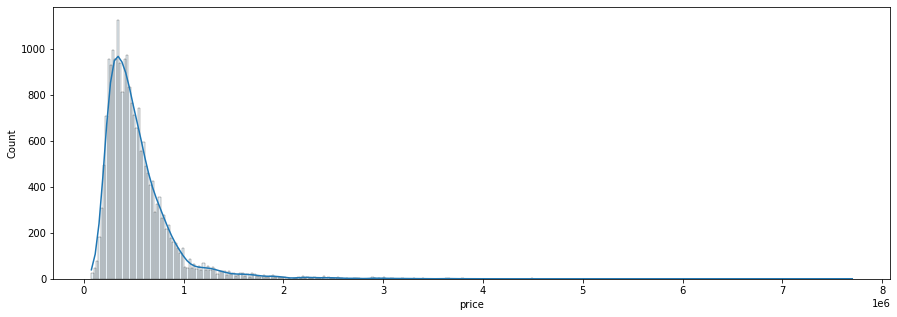

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='price'>

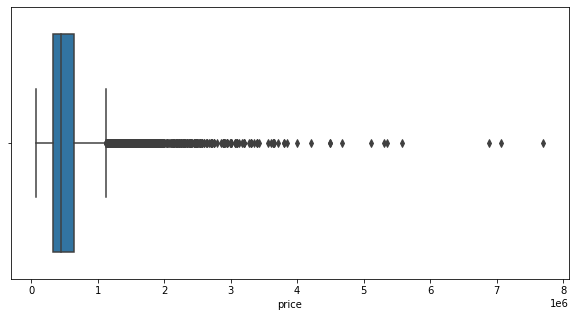

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(data=df, x='price', ax=ax)

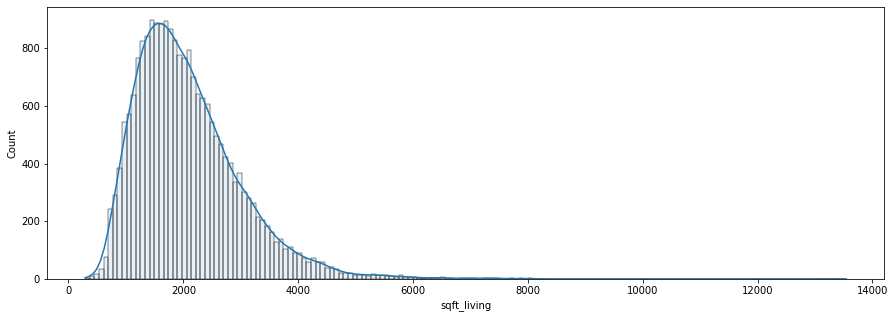

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

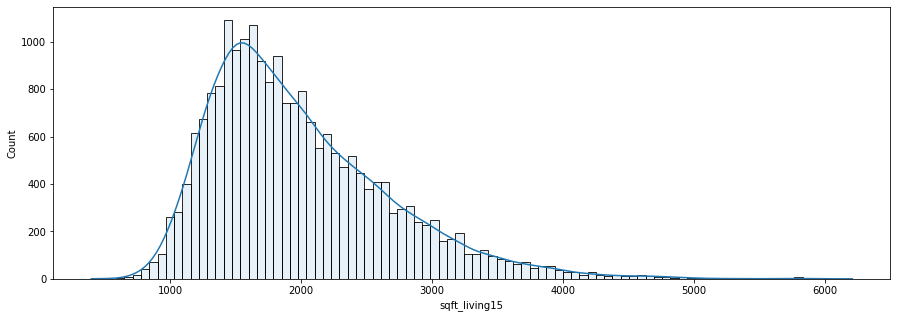

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

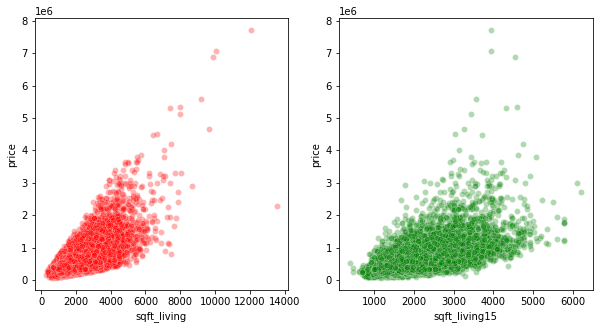

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

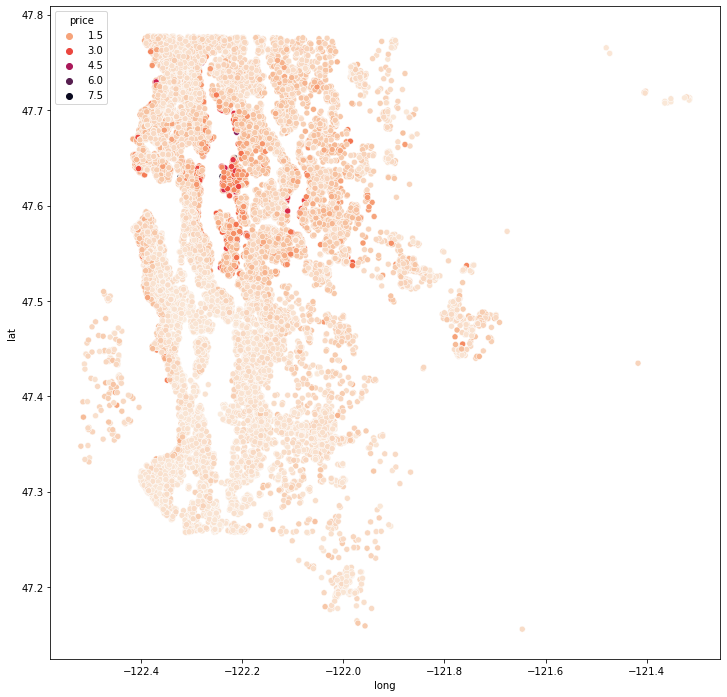

In [14]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

### Should we remove outliers?
For housing prices, a house could have been sold for a value less than what it worths. Or the house could've been sold more than what it worths. According to the red graph, some house with 13.5k sqft_living has been sold for about 2m dollars but some other house with about 12k sqft_living has been sold for about 7.5m dollars. This case could be seen as an outlier but there are other factors that have impact on the price.

In [15]:
df[df['sqft_living'] > 12000].T

id,6762700020,1225069038
bedrooms,6.000000e+00,7.000000e+00
bathrooms,8.000000e+00,8.000000e+00
sqft_living,1.205000e+04,1.354000e+04
sqft_lot,2.760000e+04,3.077520e+05
floors,2.500000e+00,3.000000e+00
view,3.000000e+00,4.000000e+00
condition,4.000000e+00,3.000000e+00
grade,1.300000e+01,1.200000e+01
sqft_above,8.570000e+03,9.410000e+03
sqft_basement,3.480000e+03,4.130000e+03


Two houses are somewhat the same and in the same area according to their lat and long. <br>
- More expensive one is older than the new one
- More expensive one's grade is greater than the other by 1 values
- sqft_lot15 is very large compared to the other one
- In 1987, the expensive house has been renovated but the other one hasn't been renovated
<br>
Other than these, the other house is better in every aspect. So why it is less expensive or not at all expensive? <br>
I'd say the first one is expensive because it is near the lake.

In [16]:
def remove_outliers(df, columns='all'):
    columns = df.columns if columns == 'all' else columns
    for c in columns:
        df = remove_columns_outlier(df, c)
    return df

def remove_columns_outlier(df, column):
    column = df[column]
    column_norm = (column - np.mean(column)) / np.std(column)
    column_norm = column_norm[~((column_norm >= 3) | (column_norm <= -3))]
    return df.loc[df.index[df.index.value_counts() == 1]]

def remove_outliers_per(df, column, per_column):
    fraction = column / per_column
    frac_norm = (fraction - np.mean(fraction)) / np.std(fraction)
    frac_norm = frac_norm[~((frac_norm >= 3) | (frac_norm <= -3))]
    return df.loc[list(frac_norm.index)]

def percentage_from_right(df, column, from_value):
    per = df[df[column] > from_value].size / df.size
    per = per * 100
    return per

def percentage_from_left(df, column, from_value):
    per = df[df[column] < from_value].size / df.size
    per = per * 100
    return per
    
def drop_tail_right(df, column, from_value, max_percentage=5, verbos=True):
    per = percentage_from_right(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    if verbos: print(f'dropping {per:.2f}% data')
    return df[df[column] < from_value]

def drop_tail_left(df, column, from_value, max_percentage=5, verbos=True):
    per = percentage_from_left(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    if verbos: print(f'dropping {per:.2f}% data')
    return df[df[column] > from_value]


def remove_outliers_IQR(df, column, verbos=True):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    res = drop_tail_right(df, column, q3 + 1.5 * IQR, 100, False)
    res = drop_tail_left(res, column, q1 - 1.5 * IQR, 100, False)
    per = percentage_from_right(df, column, q3 + 1.5 * IQR) + percentage_from_left(df, column, q1 - 1.5 * IQR)
    if verbos: print(f'dropping {per:.2f}% data')
    return res

In [17]:
#df = remove_outliers(df, ['price'])
#df = remove_outliers_per(df, df['price'], df['sqft_living'])
#df = remove_outliers_per(df, df['price'], df['sqft_above'])
#df = remove_outliers_per(df, df['price'], df['sqft_living15'])

#df = drop_tail_right(df, 'price', 969000, 8)
#df = drop_tail_right(df, 'sqft_living', 3850, 3)
#df = drop_tail_right(df, 'sqft_living15', 3500, 3)
#df = drop_tail_left(df, 'grade', 5, 5)
#df = drop_tail_right(df, 'grade', 11, 5)

df = remove_outliers_IQR(df, 'price')
#df = remove_outliers_IQR(df, 'sqft_living')
#df = df.drop('sqft_above', axis=1)

dropping 5.31% data


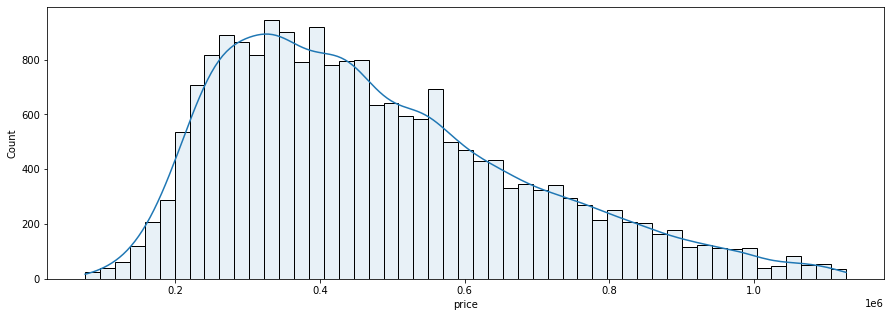

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

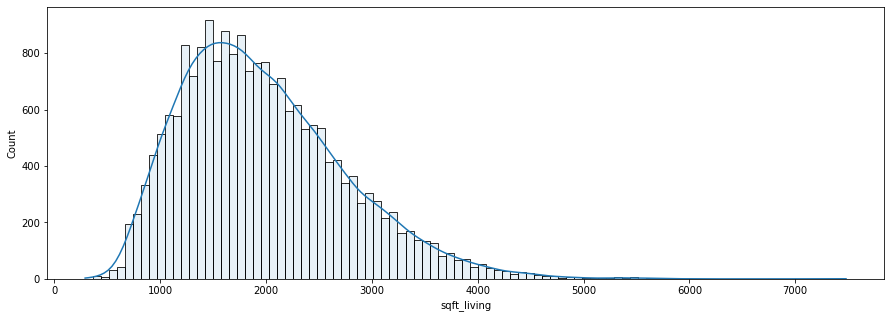

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

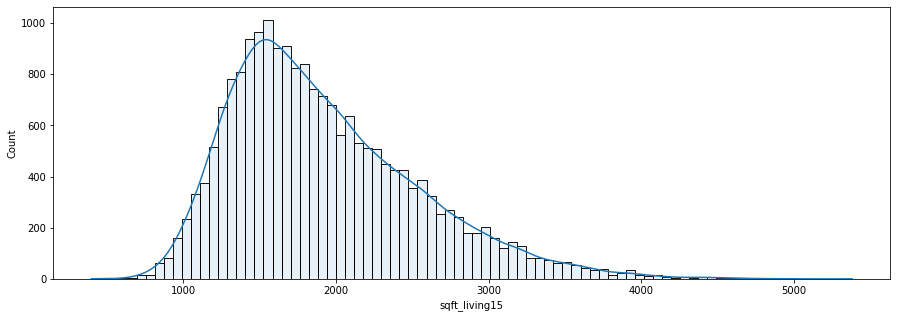

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

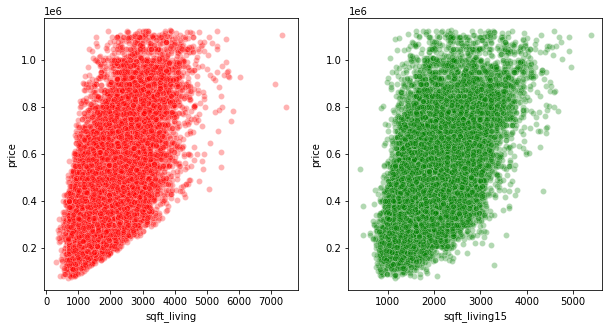

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

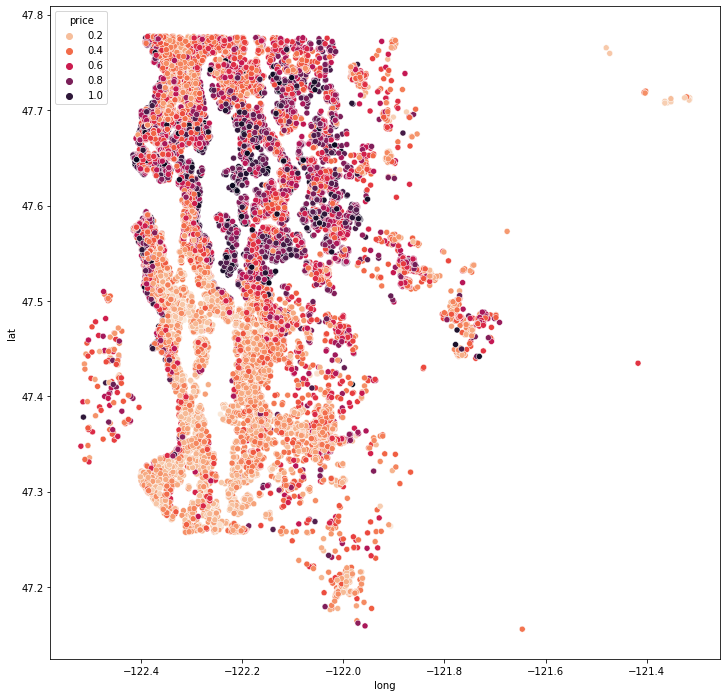

In [22]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

As it seems some regions here, have expensive houses, So we'll try to cluster each region.<br>
We'll use "lat" and "long" and "price" to cluster each using K_mean clustering algorithm.

In [23]:
selected = df[['lat', 'long', 'price']]
ids = selected.index.values
selected = selected.values
selected.shape

(20297, 3)

In [24]:
centeroids, idx = k_mean_optimization(selected, 10, 50, 20)

Iteration 1/20
Distortion: 796977615.1541004
Iteration 2/20
Distortion: 715581725.1832263
Iteration 3/20
Distortion: 725680649.1130568
Iteration 4/20
Distortion: 788035028.5785488
Iteration 5/20
Distortion: 772019739.9397403
Iteration 6/20
Distortion: 715581725.1832263
Iteration 7/20
Distortion: 715715040.6401395
Iteration 8/20
Distortion: 767205488.9635153
Iteration 9/20
Distortion: 712981968.6951098
Iteration 10/20
Distortion: 696396359.1900002
Iteration 11/20
Distortion: 715581725.1832263
Iteration 12/20
Distortion: 696396359.1900002
Iteration 13/20
Distortion: 696556491.2505659
Iteration 14/20
Distortion: 715614032.944349
Iteration 15/20
Distortion: 772434146.8197227
Iteration 16/20
Distortion: 777960055.5425007
Iteration 17/20
Distortion: 715581725.1832263
Iteration 18/20
Distortion: 767811829.4873985
Iteration 19/20
Distortion: 771300091.2360948
Iteration 20/20
Distortion: 793869926.5190358

Distortion 696396359.1900002 is chosen!


In [25]:
selected = np.c_[ids, selected, idx]
selected = pd.DataFrame(selected, columns=['id', 'lat', 'long', 'price', 'cluster'])
selected

,id,lat,long,price,cluster
0,7.129301e+09,47.5112,-122.257,221900.0,6.0
1,6.414100e+09,47.7210,-122.319,538000.0,9.0
2,5.631500e+09,47.7379,-122.233,180000.0,6.0
3,2.487201e+09,47.5208,-122.393,604000.0,8.0
4,1.954401e+09,47.6168,-122.045,510000.0,9.0
...,...,...,...,...,...
20292,2.630000e+08,47.6993,-122.346,360000.0,5.0
20293,6.600060e+09,47.5107,-122.362,400000.0,7.0
20294,1.523300e+09,47.5944,-122.299,402101.0,7.0
20295,2.913101e+08,47.5345,-122.069,400000.0,7.0


In [26]:
selected.set_index('id', inplace=True)
selected

,lat,long,price,cluster
id,,,,
7.129301e+09,47.5112,-122.257,221900.0,6.0
6.414100e+09,47.7210,-122.319,538000.0,9.0
5.631500e+09,47.7379,-122.233,180000.0,6.0
2.487201e+09,47.5208,-122.393,604000.0,8.0
1.954401e+09,47.6168,-122.045,510000.0,9.0
...,...,...,...,...
2.630000e+08,47.6993,-122.346,360000.0,5.0
6.600060e+09,47.5107,-122.362,400000.0,7.0
1.523300e+09,47.5944,-122.299,402101.0,7.0


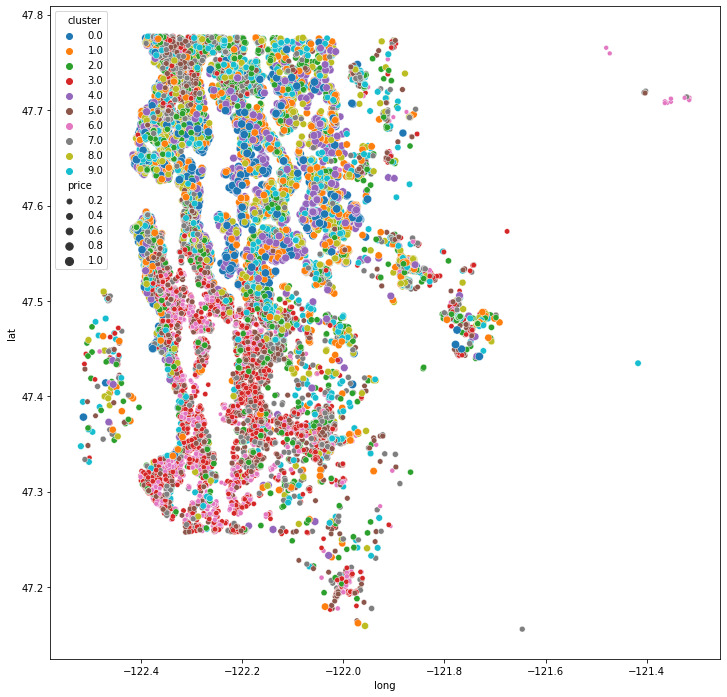

In [27]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=selected, x='long', y='lat', hue='cluster', palette='tab10', size='price');

In [28]:
clusters = pd.get_dummies(data=selected.cluster, drop_first=True, prefix='cluster')
df = pd.concat([df, clusters], axis=1)

In [29]:
df = df.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'], axis=1)

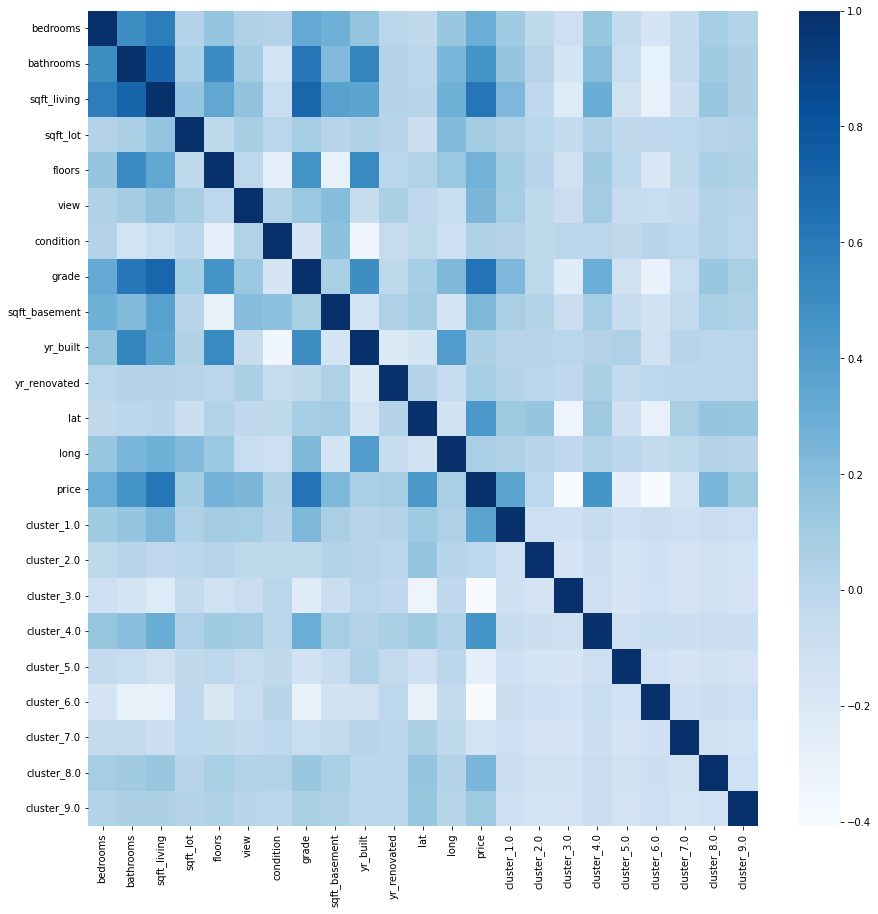

In [30]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cmap='Blues');

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,20297.0,3.330246,0.911846,0.0000,3.0000,3.0000,4.0000,3.300000e+01
bathrooms,20297.0,2.054084,0.711399,0.0000,1.5000,2.0000,2.5000,7.500000e+00
sqft_living,20297.0,1978.235158,775.491728,290.0000,1400.0000,1860.0000,2440.0000,7.480000e+03
sqft_lot,20297.0,14646.335173,40247.208902,520.0000,5000.0000,7500.0000,10321.0000,1.651359e+06
floors,20297.0,1.477854,0.537484,1.0000,1.0000,1.0000,2.0000,3.500000e+00
view,20297.0,0.173622,0.642417,0.0000,0.0000,0.0000,0.0000,4.000000e+00
condition,20297.0,3.407499,0.646790,1.0000,3.0000,3.0000,4.0000,5.000000e+00
grade,20297.0,7.535498,1.038258,1.0000,7.0000,7.0000,8.0000,1.200000e+01
sqft_basement,20297.0,267.498596,409.367450,0.0000,0.0000,0.0000,510.0000,2.720000e+03
yr_built,20297.0,1970.910874,29.168739,1900.0000,1952.0000,1975.0000,1996.0000,2.015000e+03


## Getting Data ready for trainning

In [32]:
X_train = df.drop(['price'], axis=1).values
y_train = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=123)
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

In [33]:
print(f'X_train shape is {X_train.shape} and y_train shape is {y_train.shape}')
print(f'y_cv shape is {X_cv.shape} and y_cv shape is {y_cv.shape}')
print(f'X_test shape is {X_test.shape} and y_test shape is {y_test.shape}')

X_train shape is (16237, 22) and y_train shape is (16237,)
y_cv shape is (2030, 22) and y_cv shape is (2030,)
X_test shape is (2030, 22) and y_test shape is (2030,)


### Normalize the data

In [34]:
norm = Normalization()
norm.adapt(X_train)
Xn_train = norm(X_train)
Xn_cv = norm(X_cv)
Xn_test = norm(X_test)

## Training

In [35]:
regs = [0, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7]
hist = []
for reg in regs:
    print(f'applying regularization parameter {reg}')
    s = time.time() # calculating duration
    model = Sequential([
        tf.keras.Input(shape=(Xn_train.shape[1],)),
        Dense(units=200, activation='relu', name='layer1', kernel_regularizer=L2(reg)),
        Dense(units=100, activation='relu', name='layer2', kernel_regularizer=L2(reg)),
        Dense(units=50, activation='relu', name='layer3', kernel_regularizer=L2(reg)),
        Dense(units=1, activation='linear', name='output')
    ], name='My_Model')

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.001),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    model.fit(Xn_train, y_train, validation_data=[Xn_cv, y_cv], epochs=50, verbose=False)
    hist.append([
        model.evaluate(Xn_train, y_train),
        model.evaluate(Xn_cv, y_cv), 
        model.evaluate(Xn_test, y_test)
    ])
    e = time.time() # calculating duration
    print(f'duration ~ {e - s : 0.2f}')

applying regularization parameter 0
64/64 [==============================] - 0s 776us/step - loss: 682627456.0000 - mean_absolute_error: 21055.4141
duration ~  27.67
applying regularization parameter 0.1
64/64 [==============================] - 0s 823us/step - loss: 683406848.0000 - mean_absolute_error: 21110.5684
duration ~  27.24
applying regularization parameter 1
64/64 [==============================] - 0s 776us/step - loss: 696812608.0000 - mean_absolute_error: 21131.6113
duration ~  27.29
applying regularization parameter 10
64/64 [==============================] - 0s 776us/step - loss: 703629760.0000 - mean_absolute_error: 21227.8516
duration ~  27.15
applying regularization parameter 100
64/64 [==============================] - 0s 792us/step - loss: 694422976.0000 - mean_absolute_error: 21282.1406
duration ~  27.23
applying regularization parameter 1000.0
64/64 [==============================] - 0s 792us/step - loss: 693861056.0000 - mean_absolute_error: 20995.4219
duration ~  

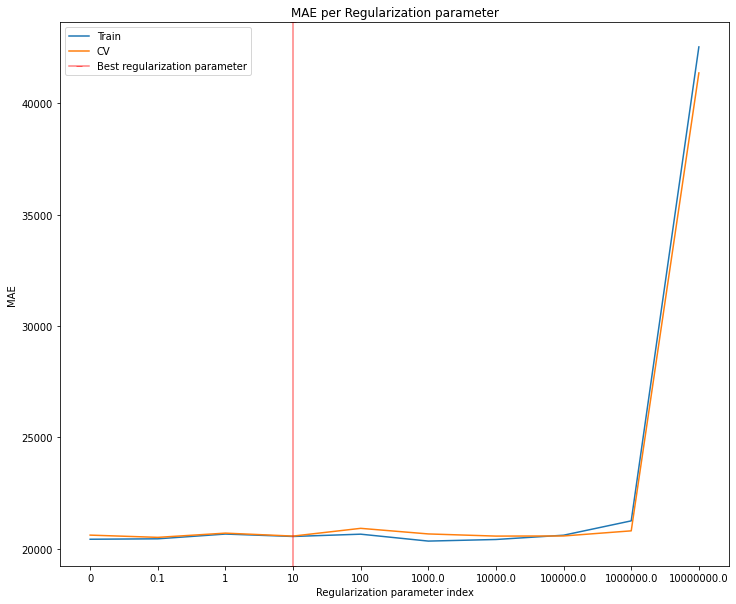

In [43]:
hist = np.array(hist)
hist_loss = hist[:, :, 0]
hist_mae = hist[:, :, 1]

m, n = hist_loss.shape

plt.figure(figsize=(12, 10))
plt.plot(range(m), hist_mae[:, 0], label='Train')
plt.plot(range(m), hist_mae[:, 1], label='CV')
#plt.plot(range(m), hist_mae[:, 2], label='Test')
plt.axvline(x=3, marker="_", c='r', label='Best regularization parameter', alpha=0.5)
plt.title('MAE per Regularization parameter');
plt.xlabel('Regularization parameter index');
plt.ylabel('MAE');
ax = plt.gca()
ax.set_xticks(range(10))
ax.set_xticklabels([0, 0.1, 1, 10, 100, 1e3, 1e4, 1e5, 1e6, 1e7])
plt.legend();

In [44]:
reg = 10
model = Sequential([
    tf.keras.Input(shape=(Xn_train.shape[1],)),
    Dense(units=200, activation='relu', name='layer1', kernel_regularizer=L2(reg)),
    Dense(units=100, activation='relu', name='layer2', kernel_regularizer=L2(reg)),
    Dense(units=50, activation='relu', name='layer3', kernel_regularizer=L2(reg)),
    Dense(units=1, activation='linear', name='output')
], name='My_Model')

model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

history = model.fit(Xn_train, y_train, validation_data=[Xn_cv, y_cv], epochs=100, verbose=True)

Epoch 1/100
508/508 [==============================] - 1s 1ms/step - loss: 156012167168.0000 - mean_absolute_error: 331593.9375 - val_loss: 22454435840.0000 - val_mean_absolute_error: 116965.6406
Epoch 2/100
508/508 [==============================] - 1s 1ms/step - loss: 14926071808.0000 - mean_absolute_error: 89588.0547 - val_loss: 8920987648.0000 - val_mean_absolute_error: 65748.6094
Epoch 3/100
508/508 [==============================] - 1s 1ms/step - loss: 7362549248.0000 - mean_absolute_error: 56790.1055 - val_loss: 5122059776.0000 - val_mean_absolute_error: 47316.0625
Epoch 4/100
508/508 [==============================] - 1s 1ms/step - loss: 4441942016.0000 - mean_absolute_error: 43213.4609 - val_loss: 3140048128.0000 - val_mean_absolute_error: 37591.5547
Epoch 5/100
508/508 [==============================] - 1s 1ms/step - loss: 2692910592.0000 - mean_absolute_error: 34659.7109 - val_loss: 1888000256.0000 - val_mean_absolute_error: 30103.9727
Epoch 6/100
508/508 [==================

508/508 [==============================] - 1s 1ms/step - loss: 655454016.0000 - mean_absolute_error: 20544.1230 - val_loss: 654978880.0000 - val_mean_absolute_error: 20560.4570
Epoch 45/100
508/508 [==============================] - 1s 1ms/step - loss: 655377088.0000 - mean_absolute_error: 20547.0625 - val_loss: 665510400.0000 - val_mean_absolute_error: 20721.3281
Epoch 46/100
508/508 [==============================] - 1s 1ms/step - loss: 657712256.0000 - mean_absolute_error: 20582.7344 - val_loss: 660241920.0000 - val_mean_absolute_error: 20664.9863
Epoch 47/100
508/508 [==============================] - 1s 1ms/step - loss: 654915328.0000 - mean_absolute_error: 20532.3164 - val_loss: 653512384.0000 - val_mean_absolute_error: 20576.6348
Epoch 48/100
508/508 [==============================] - 1s 1ms/step - loss: 655041536.0000 - mean_absolute_error: 20539.3438 - val_loss: 653762176.0000 - val_mean_absolute_error: 20542.4863
Epoch 49/100
508/508 [==============================] - 1s 1ms/

508/508 [==============================] - 1s 1ms/step - loss: 648700288.0000 - mean_absolute_error: 20449.4648 - val_loss: 670961344.0000 - val_mean_absolute_error: 20613.6641
Epoch 88/100
508/508 [==============================] - 1s 1ms/step - loss: 648406400.0000 - mean_absolute_error: 20470.1797 - val_loss: 666397952.0000 - val_mean_absolute_error: 20582.4199
Epoch 89/100
508/508 [==============================] - 1s 1ms/step - loss: 650013888.0000 - mean_absolute_error: 20461.5312 - val_loss: 686015360.0000 - val_mean_absolute_error: 20891.9121
Epoch 90/100
508/508 [==============================] - 1s 1ms/step - loss: 651055808.0000 - mean_absolute_error: 20491.5234 - val_loss: 663341888.0000 - val_mean_absolute_error: 20760.1406
Epoch 91/100
508/508 [==============================] - 1s 1ms/step - loss: 647346304.0000 - mean_absolute_error: 20438.1855 - val_loss: 662016192.0000 - val_mean_absolute_error: 20684.8633
Epoch 92/100
508/508 [==============================] - 1s 1ms/

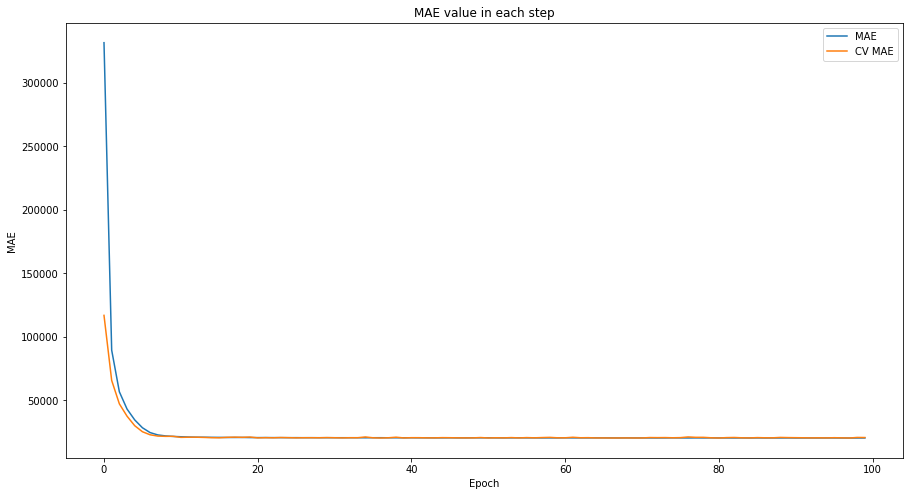

In [45]:
losses = np.array(history.history['loss'])
MAE = np.array(history.history['mean_absolute_error'])
val_losses = np.array(history.history['val_loss'])
val_MAE = np.array(history.history['val_mean_absolute_error'])

plt.figure(figsize=(15, 8))
plt.plot(range(MAE.size), MAE, label='MAE');
plt.plot(range(val_MAE.size), val_MAE, label='CV MAE');
plt.title('MAE value in each step')
plt.xlabel('Epoch');
plt.ylabel('MAE');
plt.legend();

In [46]:
J_abs_train = model.evaluate(Xn_train, y_train, verbose=False)[1]
J_abs_cv = model.evaluate(Xn_cv, y_cv, verbose=False)[1]
J_abs_test = model.evaluate(Xn_test, y_test, verbose=False)[1]

print(f'Absolute error for training set is {J_abs_train}')
print(f'Absolute error for cross validation set is {J_abs_cv}')
print(f'Absolute error for test set is {J_abs_test}')

Absolute error for training set is 20535.875
Absolute error for cross validation set is 20809.8515625
Absolute error for test set is 20916.19140625


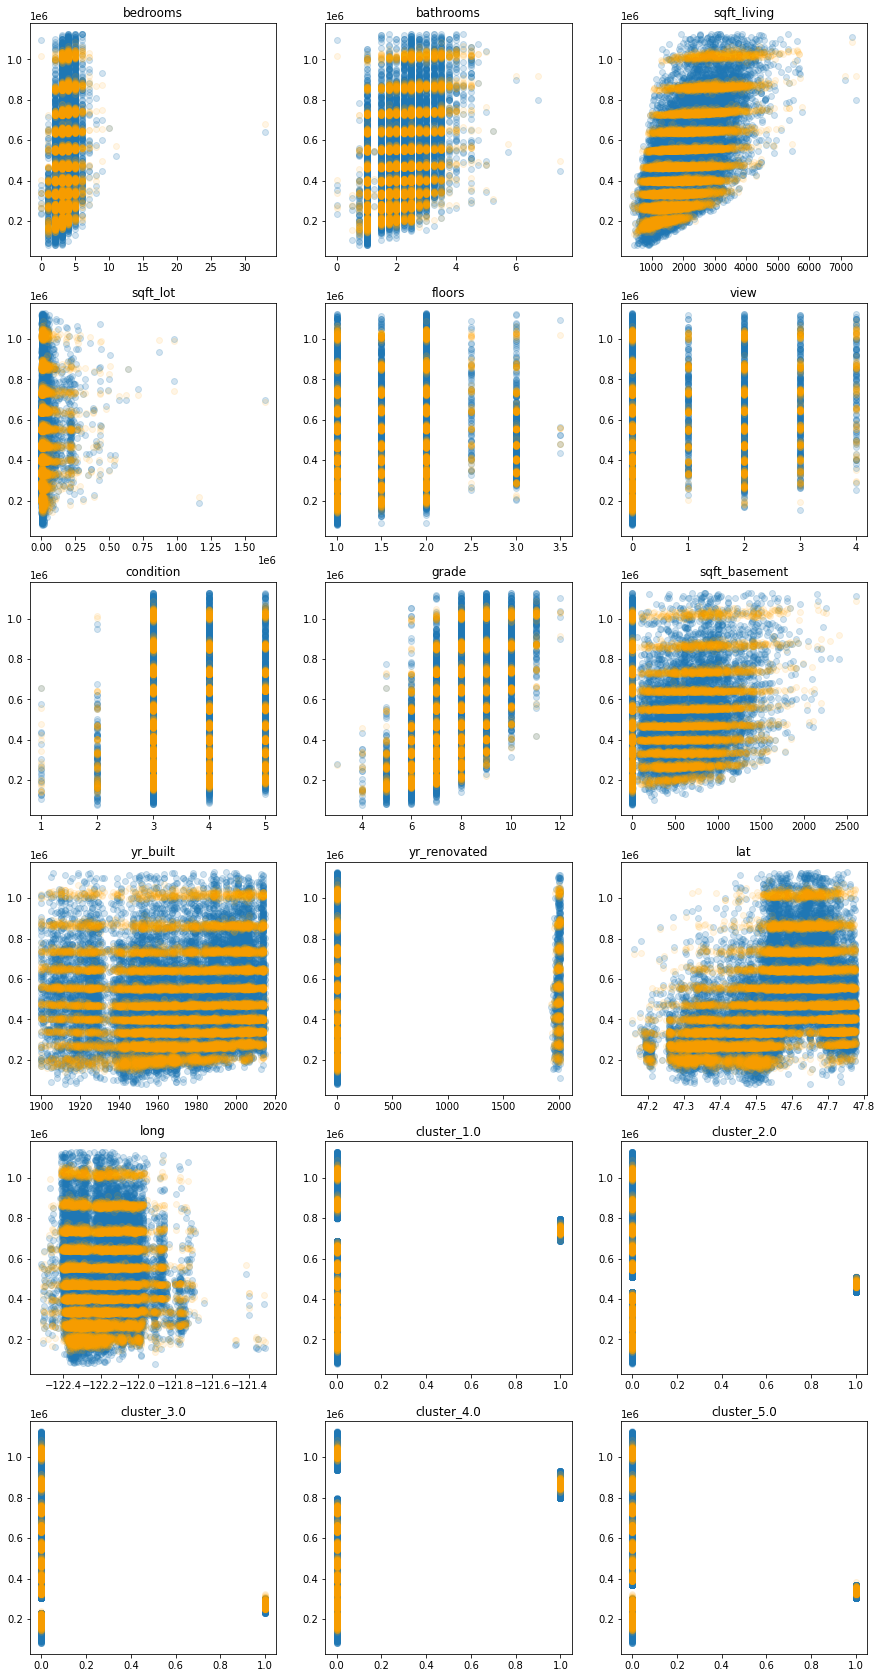

In [47]:
fig, ax = plt.subplots(6, 3, figsize=(15, 30))
m, n = Xn_train.shape
cnt = 0
for ax in ax.flatten():
    try:
        if cnt >= n:
            ax.set_visible(False)
            continue
        newy = model.predict(Xn_train, verbose=False);
        ax.scatter(X_train[:, cnt], y_train, alpha=0.2)
        ax.scatter(X_train[:, cnt], newy, alpha=0.1, c='orange')
        ax.set_title(df.drop('price', axis=1).columns[cnt])
        cnt += 1
    except:
        ax.set_visible(False)
        continue

In [48]:
X_all = df.drop(['price'], axis=1).values
Xn_all = norm(X_all)
p_df = df.copy(deep=True)
p_df['Predicted'] = model.predict(Xn_all).astype('int64')
p_df

635/635 [==============================] - 0s 717us/step


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_basement,yr_built,...,cluster_1.0,cluster_2.0,cluster_3.0,cluster_4.0,cluster_5.0,cluster_6.0,cluster_7.0,cluster_8.0,cluster_9.0,Predicted
id,,,,,,,,,,,,,,,,,,,,,
7.129301e+09,3,1.00,1180,5650,1.0,0,3,7,0,1955,...,0,0,0,0,0,1,0,0,0,195365
6.414100e+09,3,2.25,2570,7242,2.0,0,3,7,400,1951,...,0,0,0,0,0,0,0,0,1,568708
5.631500e+09,2,1.00,770,10000,1.0,0,3,6,0,1933,...,0,0,0,0,0,1,0,0,0,189637
2.487201e+09,4,3.00,1960,5000,1.0,0,5,7,910,1965,...,0,0,0,0,0,0,0,1,0,643216
1.954401e+09,3,2.00,1680,8080,1.0,0,3,8,0,1987,...,0,0,0,0,0,0,0,0,1,549068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.630000e+08,3,2.50,1530,1131,3.0,0,3,8,0,2009,...,0,0,0,0,1,0,0,0,0,345214
6.600060e+09,4,2.50,2310,5813,2.0,0,3,8,0,2014,...,0,0,0,0,0,0,1,0,0,397498
1.523300e+09,2,0.75,1020,1350,2.0,0,3,7,0,2009,...,0,0,0,0,0,0,1,0,0,390031


In [49]:
p_df.to_csv('output_NN.csv', index=True)

### Best OR Worst?
For better accuracy, a very complex model is created and tuned using regularization parameter (Totally addresses the problem of high variance i.e. overfitting). This model is proper for using in suggestions and predictions for the following reason
- The model has slightly better accuracy then polynomial regression and linear regression
If we are strict about our MAE, this would be a better choice over polynomial regression and linear regression; <br>
The downside of this model is its complexity; just looking at the weights, it would be impossible to understand what these weights represent. Traning and implementing takes a lot of time. And for prediction takes much more time compared to other models.
> There seem to be a trade off between completeness (i.e. variance and bias, low MAE) of a model and time taken, complexity